<a href="https://colab.research.google.com/github/vblagoje/haystack-cookbook/blob/main/notebooks/chat_rag_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💾 Chat + RAG + Memory
<a target="_blank" href="https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/chat_rag_memory.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" width="200" alt="Open In Colab"/>
</a>



A simple RAG + Chat example while storing previous messages from user and assistant.

>[💾 Chat + RAG + Memory](#scrollTo=UmuZmn1hN3NB&)

>>[Installation](#scrollTo=1LRwBMJdF_d1)

>>[OpenAI API Key](#scrollTo=lJokyTRiPifH)

>>[Pipeline](#scrollTo=8DX-cZ6IQUf9)

>>>[DocumentStore](#scrollTo=avfIcgYlP5BE)

>>>[Connect pipeline components](#scrollTo=tCOdSoAAQBb6)

>>>[Let's ask some questions!](#scrollTo=BmtRP897RgOc)

## Installation

In [1]:
!pip install -q git+https://github.com/deepset-ai/haystack-experimental.git haystack-ai


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.3/350.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.3/361.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.1 MB/s eta 0:00:00


## Enter OpenAI API key

In [2]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


## Build the Pipeline

### Create DocumentStore with sample docs + Memory

In [3]:
from typing import List
from haystack import Document, Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.joiners import BranchJoiner
from haystack.dataclasses import ChatMessage
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.document_stores.in_memory import InMemoryDocumentStore

# Chat memory imports
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter


document_store = InMemoryDocumentStore()
documents = [Document(content="There are over 7,000 languages spoken around the world today."),
             Document(content="Chinese language boasts the highest number of native speakers."),
			       Document(content="Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors."),
			       Document(content="In certain parts of the world, like the Maldives, Puerto Rico, and San Diego, you can witness the phenomenon of bioluminescent waves.")]
document_store.write_documents(documents=documents)


# Chat memory components
memory_store = InMemoryChatMessageStore()
memory_retriever = ChatMessageRetriever(memory_store)
memory_writer = ChatMessageWriter(memory_store)

## Connect all the pipeline components

In [4]:
# components for RAG
pipeline = Pipeline()
pipeline.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["query", "documents", "memories"], required_variables=["query", "documents", "memories"]))
pipeline.add_component("llm", OpenAIChatGenerator(model="gpt-4o"))

# components for memory
pipeline.add_component("memory_retriever", memory_retriever)
pipeline.add_component("memory_writer", memory_writer)
pipeline.add_component("memory_joiner", BranchJoiner(List[ChatMessage]))

# connections for RAG
pipeline.connect("retriever.documents", "prompt_builder.documents")
pipeline.connect("prompt_builder.prompt", "llm.messages")
pipeline.connect("llm.replies", "memory_joiner")


# connections for memory
pipeline.connect("memory_joiner", "memory_writer")
pipeline.connect("memory_retriever", "prompt_builder.memories")


system_message = ChatMessage.from_system("You are a helpful AI assistant using provided supporting documents and conversation history to assist humans")
user_message_template ="""Given the conversation history and the provided supporting documents, answer the question.
Note that supporting documents are not part of the conversation. If question can't be answered from supporting documents use your general knowledge and answer anyway.

    Conversation history:
    {% for memory in memories %}
        {{ memory.content }}
    {% endfor %}

    Supporting documents:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{query}}
    \nAnswer:
"""
user_message = ChatMessage.from_user(user_message_template)



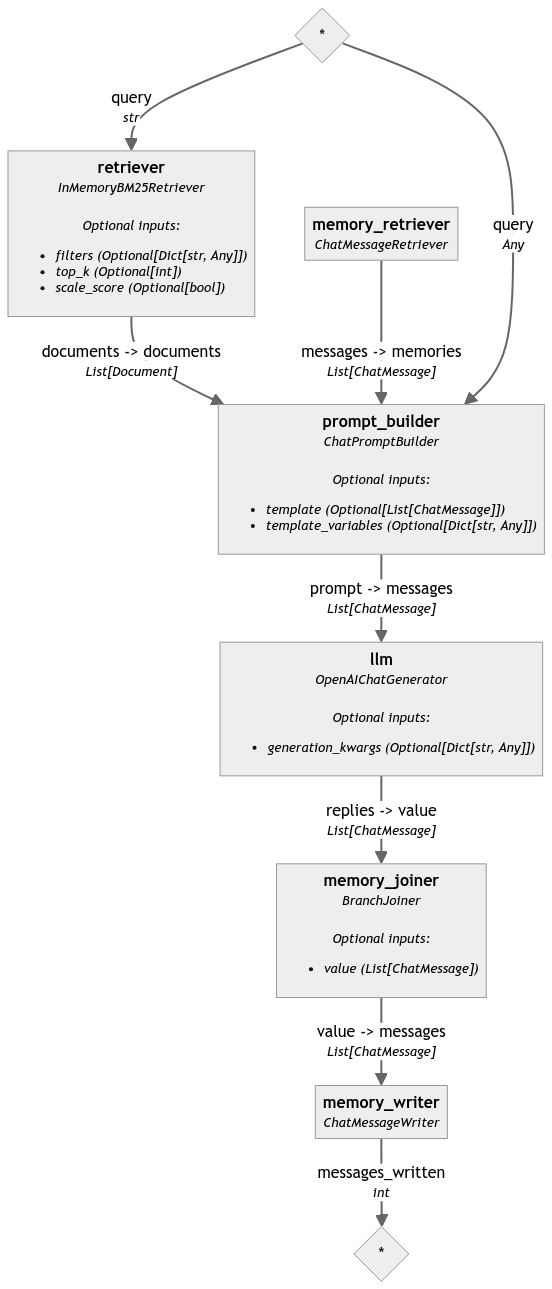

In [5]:
pipeline.show()

## Let's ask some questions 😀

In [ ]:
# How many languages are there?
# What is the one with most native speakers?
# Do you remember the two answers you gave to me before?

while True:
    messages = [system_message, user_message]
    question = input("Enter your question or Q to exit. Example: How many languages are there?\n🧑 ")
    if question=="Q":
        break

    res = pipeline.run(data={"retriever": {"query": question},
                             "prompt_builder": {"template": messages, "query": question},
                             "memory_joiner": {"value": [ChatMessage.from_user(question)]}},
                       include_outputs_from=["llm", "prompt_builder","memory_writer"])
    print(res["prompt_builder"])
    print(res["memory_writer"])
    assistant_resp = res['llm']['replies'][0]
    print(f"🤖 {assistant_resp.content}")

Enter your question or Q to exit. Example: How many languages are there?
🧑 How many languages are there?
{'prompt': [ChatMessage(content='You are a helpful AI assistant using provided supporting documents and conversation history to assist humans', role=<ChatRole.SYSTEM: 'system'>, name=None, meta={}), ChatMessage(content="Given the conversation history and the provided supporting documents, answer the question.\nNote that supporting documents are not part of the conversation. If question can't be answered from supporting documents use your general knowledge and answer anyway.\n\n    Conversation history:\n    \n        How many languages are there?\n    \n\n    Supporting documents:\n    \n        There are over 7,000 languages spoken around the world today.\n    \n        Chinese language boasts the highest number of native speakers.\n    \n        Elephants have been observed to behave in a way that indicates a high level of self-awareness, such as recognizing themselves in mirrors.